In [1]:
#imports

import numpy as np
from sklearn import manifold
from dreimac import GeometryUtils, CircleMapUtils, CircularCoords
from ripser import ripser
from persim import plot_diagrams
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from plotly.subplots import make_subplots
from scipy.sparse.csgraph import shortest_path

In [3]:
#generating and plotting torus data in R3

np.random.seed(2)
n_data = 2500
R = 5
r = 2
data = np.zeros((n_data, 3))
s = np.random.rand(n_data)*2*np.pi
t = np.random.rand(n_data)*2*np.pi

data[:, 0] = (R + r*np.cos(s))*np.cos(t)
data[:, 1] = (R + r*np.cos(s))*np.sin(t)
data[:, 2] = r*np.sin(s)
data += 0.1*np.random.randn(*data.shape)

# Plot the data 
fig = go.Figure(data=[go.Scatter3d(
    x=data[:,0], y=data[:,1], z=data[:,2], 
    mode ='markers', 
    marker=dict(size = 1.5 , color = 'grey'))])

fig.update_layout( showlegend=False )
fig.show(renderer='iframe')

In [4]:
print(data.shape)

(2500, 3)


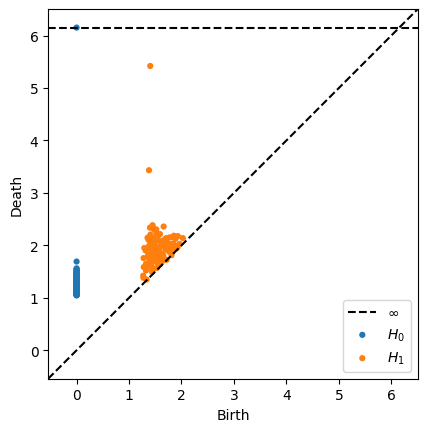

In [5]:
#persistence diagram for the Torus

n_lands = 200

cc = CircularCoords(data, n_landmarks=n_lands)

plot_diagrams(cc.dgms_)

In [9]:
coho_classes = [0, 1]

circular_coords = []

for i in coho_classes:
    theta = cc.get_coordinates(perc= 0, cocycle_idx=i)
    theta = CircleMapUtils.center(theta)
    #theta = CircleMapUtils.to_sinebow(np.pi + CircleMapUtils.center(theta))
    circular_coords.append(theta)

In [10]:
fig = make_subplots(rows=1, cols=len(coho_classes), 
                    subplot_titles = tuple('Circ Coord '+str(i+1) for i in coho_classes),
                    specs = [[{'type': 'scatter3d'} for i in coho_classes]])

for i, coord in enumerate(circular_coords):
    fig.add_trace(
        go.Scatter3d(x=data.T[0], y=data.T[1], z=data.T[2],   mode ='markers', 
        marker=dict(size = 2 , color =  circular_coords[i])),  
        row=1, col=i+1)
    fig.update_scenes(xaxis=dict( ticks='', showticklabels=False), 
                      yaxis=dict( ticks='', showticklabels=False), 
                      zaxis=dict( ticks='', showticklabels=False), 
                      aspectmode='data', row=1, col=i+1)

fig.update_layout( showlegend=False )
fig.show(renderer='iframe')

In [157]:
#take in cuts as a list circular coordinate arrays

cuts=[circular_coords[0],circular_coords[1]]

#calculate the k nearest neighbors graph

n_land = 900
k_neigh = 20
nbrs = NearestNeighbors(n_neighbors=k_neigh, algorithm='ball_tree').fit(data)
distances, indices = nbrs.kneighbors(data)

#the output is a list of pairs of ndarrays that has length n_data. For any row (each representing a point),
#the first element of the pair is the indices in the data for the k nearest points
#and the second element is the distance between each point and the current row (point).
simplicial_complex=[[indices[i],distances[i]] for i in range(len(indices))]

In [158]:
print(len(simplicial_complex))

2500


In [159]:
#this function makes cuts and takes in a list of circular coords arrays as well as a neighbor graph and outputs a cut graph
def cut_neighbors(cuts, neighbor_graph):
    removals=0
    for ind, point in enumerate(neighbor_graph):
        counts=[]
        for count, i in enumerate(point[0]):
            if any(np.abs(cut[ind]-cut[i]) > np.pi for cut in cuts):
                counts.append(count)
                removals+=1
        neighbor_graph[ind][0]=np.delete(neighbor_graph[ind][0],counts)
        neighbor_graph[ind][1]=np.delete(neighbor_graph[ind][1],counts)
    print('Removals: ',removals)
    return neighbor_graph

new_neighbor_graph=cut_neighbors(cuts, simplicial_complex)

Removals:  1790


In [160]:
#now we transform our cut up graph into a numpy distance matrix and then a compressed sparse matrix
#we can do this because out neighbors graph contained distance data in it

kneighbors_graph=np.zeros((n_data,n_data))
for count, info in enumerate(simplicial_complex):
    for place, ind in enumerate(info[0]):
        kneighbors_graph[count,ind]=info[1][place]
kneighbors_graph=csr_matrix(kneighbors_graph)

In [161]:
#calculating geodesic distance matrix

n_landmarks=800

n_points = data.shape[0]
perm = np.zeros(n_landmarks, dtype=np.int64)
lambdas = np.zeros(n_landmarks)
ds = shortest_path(kneighbors_graph, indices=0, directed=False)
D = np.zeros((n_landmarks, n_points))
D[0, :] = ds
for i in range(1, n_landmarks):
    idx = np.argmax(ds)
    perm[i] = idx
    lambdas[i] = ds[idx]
    thisds = shortest_path(kneighbors_graph, indices=idx, directed=False)
    D[i, :] = thisds
    ds = np.minimum(ds, thisds)

perm_rest_points = np.setdiff1d(
np.arange(0, n_points, dtype=int), perm, assume_unique=True
)
perm_all_points = np.concatenate((perm, perm_rest_points))

dist_landmarks_points = D[:, perm_all_points]

In [164]:
#check that the distance matrix has no infinity values

inf_in_mat=[]
for i in dist_landmarks_points:
    inf_in_mat.append(list(np.isinf(i)).count(True)==0)

print('Distance matrix has no infinity values: ',all(inf_in_mat))

distance matrix has no infinity values:  True


In [165]:
#using scipy to calculate the multi-dimensional scaling of the distance matrix

mds= manifold.MDS(
    n_components=2,
    metric=True,
    dissimilarity="precomputed",
    normalized_stress='auto'
)
unfolding = mds.fit_transform(dist_landmarks_points[:,0:dist_landmarks_points.shape[0]])

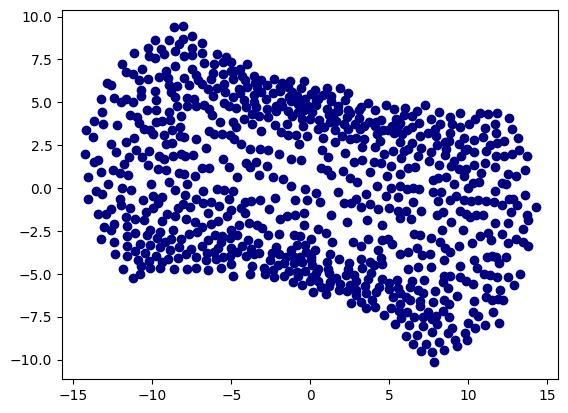

In [166]:
plt.scatter(unfolding[:, 0], unfolding[:, 1], color="navy")